# A quick look at the depth-age relationship for the seafloor.

We can now try to do what we set out to do - obtain values on an appropriate grid and see what the data look like.


## First a grid at fine resolution

In [1]:
import stripy
import numpy as np

even_mesh = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, tree=True, refinement_levels=6)
number_of_mesh_points = even_mesh.npoints

latitudes_in_radians = even_mesh.lats
latitudes_in_degrees = np.degrees(latitudes_in_radians) 

longitudes_in_radians = even_mesh.lons 
longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

## Have a look

Here we plot the points on the globe to demonstrate that the points are evenly spaced and sufficiently well resolved

/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


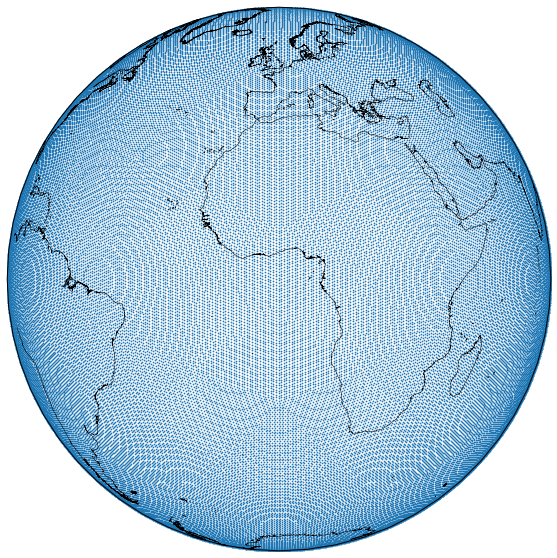

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(longitudes_in_degrees, latitudes_in_degrees, s=0.5,
            transform=ccrs.PlateCarree())

## Find the age and depth values on these points 

Now we interpolate each of our datasets to the same set of grid points. First we need 
to define the interpolation routine again.

In [3]:
def map_raster_to_mesh(mesh, latlongrid):
    
    raster = latlongrid.T

    latitudes_in_radians  = mesh.lats
    longitudes_in_radians = mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

    dlons = np.mod(longitudes_in_degrees+180.0, 360.0)
    dlats = np.mod(latitudes_in_degrees+90, 180.0)

    ilons = raster.shape[0] * dlons / 360.0
    ilats = raster.shape[1] * dlats / 180.0

    icoords = np.array((ilons, ilats))

    from scipy import ndimage

    mvals = ndimage.map_coordinates(raster, icoords , order=3, mode='nearest').astype(np.float)
    
    return mvals

## Interpolate age data to fine, triangular grid.

(You can plot the results as before to see that you have not made a mistake)

``` python 
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(longitudes_in_degrees, latitudes_in_degrees, c=meshages, cmap="RdYlBu",
            vmin=0, vmax=250, s=5,
            transform=ccrs.Geodetic())
```

In [4]:
import xarray

age_dataset = "../Data/age.3.6.nc"
age_data = xarray.open_dataset(age_dataset)
subs_data = age_data.sel(x=slice(-180,180, 1), y=slice(-90, 90, 1))

lons = subs_data.coords.get('x')
lats = subs_data.coords.get('y')
vals = subs_data['z']

x,y = np.meshgrid(lons.data, lats.data)
age = vals.data / 100.0
age[np.isnan(age)] = -1.0

meshages = map_raster_to_mesh(even_mesh, age)

ModuleNotFoundError: No module named 'xarray'

## Interpolate height data to fine, triangular grid.

(You can plot the results as before to see that you have not made a mistake)

You also should make a decision about the resolution of the data you want to download.

```python
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.1))

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.scatter(longitudes_in_degrees, latitudes_in_degrees, c=meshheights, cmap="terrain",
            vmin=-5000, vmax=5000, s=2,
            transform=ccrs.Geodetic())
```

In [5]:
(left, bottom, right, top) = (-180, -90, 180, 90)
map_extent = ( left, right, bottom, top)

etopo_dataset = "http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/ETOPO1_Bed_g_gmt4.nc"
etopo_data = xarray.open_dataset(etopo_dataset)
subs_data = etopo_data.sel(x=slice(left,right, 180), y=slice(bottom, top, 180))

lons = subs_data.coords.get('x')
lats = subs_data.coords.get('y')
vals = subs_data['z']

x,y = np.meshgrid(lons.data, lats.data)
height = vals.data

meshheights = map_raster_to_mesh(even_mesh, height)

NameError: name 'xarray' is not defined

NameError: name 'meshages' is not defined

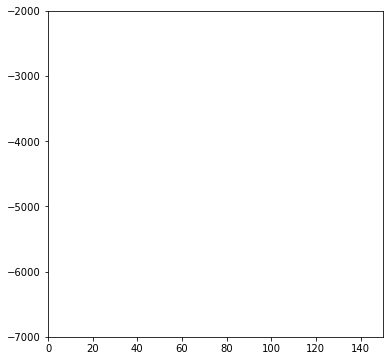

In [6]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.set_xlim(0,150)
ax.set_ylim(-7000,-2000)

plt.scatter( meshages[meshheights<-2000], meshheights[meshheights<-2000])
plt.savefig("MyAwesomePlot.png", dpi=250)

## Oh No !!

That looks terrible doesn't it ?  But all is not lost ... 

## Exercise

Try this: make the points smaller (`s=1.0`) and make them a bit see-through (`alpha=0.2`) and now take a look.
Increase the resolution of your samples in topography. That might make a difference too. 
Finally, how about trying more grid points ?